In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, compute_log_likelihood_by_week 

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]



In [18]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
    
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points
Loaded 160 points
Loaded 170 points
Loaded 180 points
Loaded 190 points
Loaded 200 points
Loaded 210 points
Loaded 220 points
Loaded 230 points
Loaded 240 points
Loaded 250 points
Loaded 260 points
Loaded 270 points
Loaded 280 points
Loaded 290 points
Loaded 300 points
Loaded 310 points
Loaded 320 points
Loaded 330 points
Loaded 340 points
Loaded 350 points
Loaded 360 points
Loaded 370 points
Loaded 380 points
Loaded 390 points
Loaded 400 points
Loaded 410 points
Loaded 420 points
Loaded 430 points
Loaded 440 points
Loaded 450 points
Loaded 460 points
Loaded 470 points
Loaded 480 points
Loaded 490 points
Loaded 500 points
Loaded 510 points
Loaded 520 points
Loaded 530 points
Loaded 540 points
Loaded 550 points
Loaded 560 points
L

In [19]:
len(sampled_points)

1000

In [20]:
from fall_2021_projection_utils import get_positives_by_week, get_true_positives_by_week
from scipy.stats import poisson
def compute_log_likelihood_by_week_(simulated_cumulative_trajs, eps=1e-5):
    simulated_positives_by_week = get_positives_by_week(simulated_cumulative_trajs)
    true_positives_by_week = get_true_positives_by_week()
    loglik = 0
    for true_positives, simulated_positives in zip(true_positives_by_week, 
                                                   simulated_positives_by_week):                                                    
        loglik += np.log(poisson.pmf(true_positives, simulated_positives) + eps)
    
    return loglik

In [21]:
import numpy as np
logliks = {}
for f in sampled_points:
    logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)

/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [22]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx])
        param_logliks[param].append(logliks[f])
    

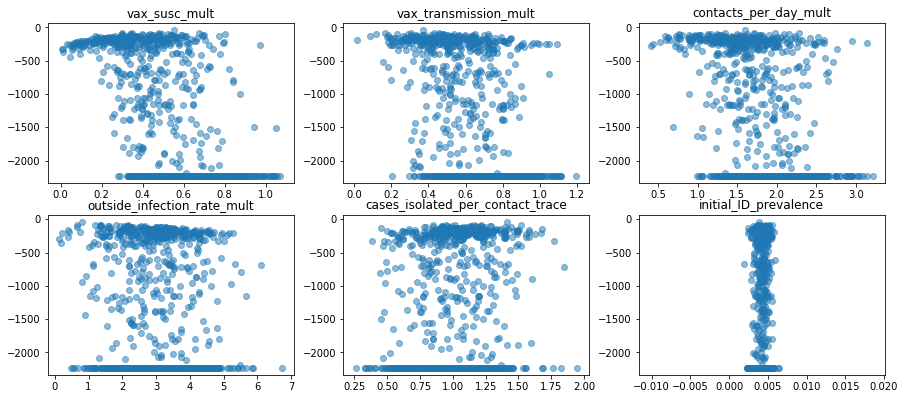

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


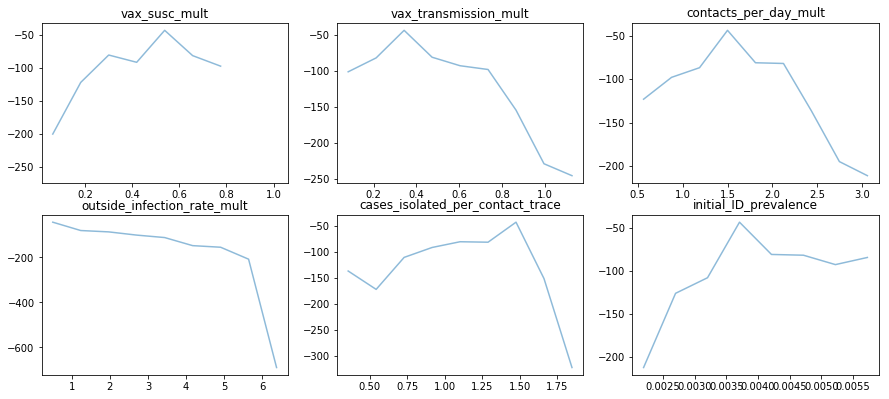

In [24]:
def estimate_marginal_dist(param_vals, logliks):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=10)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.log(np.sum(likelihoods))
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(param_vals[param], param_logliks[param])
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

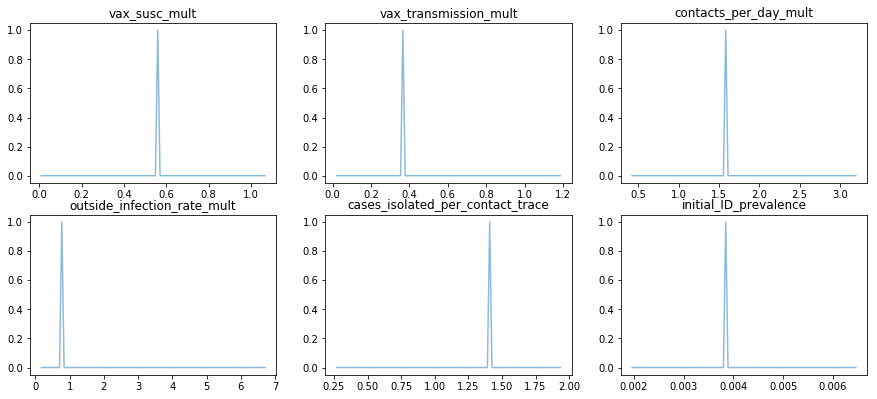

In [25]:
def estimate_marginal_dist(param_vals, logliks):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=100)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik - np.max(logliks)) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.sum(likelihoods)
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(param_vals[param], param_logliks[param])
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

Text(0.5,1,'distribution of log likelihoods using weekly aggregation')

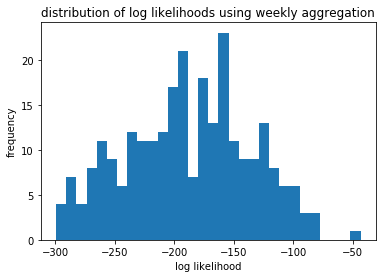

In [33]:
plt.hist([x for x in param_logliks[UNCERTAINTY_PARAMS[0]] 
          if x != float('-inf') and x >= -300], bins=30)
plt.xlabel("log likelihood")
plt.ylabel("frequency")
plt.title("distribution of log likelihoods using weekly aggregation")

In [28]:
import pandas as pd
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
df.shape

(1000, 8)

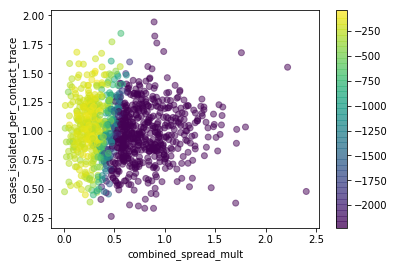

In [29]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

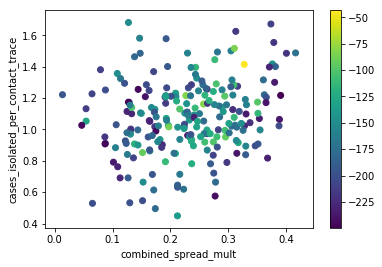

In [31]:
subdf = df[df['log_likelihood'] >= -250]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

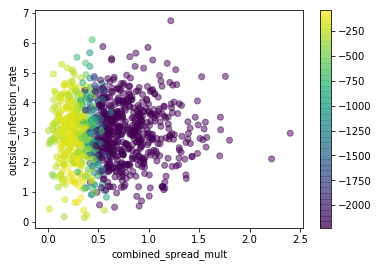

In [34]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



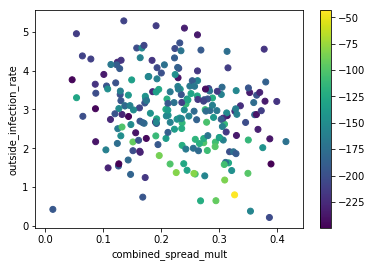

In [35]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()